<a href="https://colab.research.google.com/github/viswakimi/swiggy-Restaurant-Recommendation-System/blob/main/Swiggy%E2%80%99s_Restaurant_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
data=pd.read_csv("/content/drive/MyDrive/guvii/projects dataset/swiggy.csv")

# 1. Data Understanding and Cleaning


In [6]:
data.head(5)

,id,name,city,rating,rating_count,cost,cuisine,lic_no,link,address,menu
0,567335,AB FOODS POINT,Abohar,--,Too Few Ratings,₹ 200,"Beverages,Pizzas",22122652000138,https://www.swiggy.com/restaurants/ab-foods-po...,"AB FOODS POINT, NEAR RISHI NARANG DENTAL CLINI...",Menu/567335.json
1,531342,Janta Sweet House,Abohar,4.4,50+ ratings,₹ 200,"Sweets,Bakery",12117201000112,https://www.swiggy.com/restaurants/janta-sweet...,"Janta Sweet House, Bazar No.9, Circullar Road,...",Menu/531342.json
2,158203,theka coffee desi,Abohar,3.8,100+ ratings,₹ 100,Beverages,22121652000190,https://www.swiggy.com/restaurants/theka-coffe...,"theka coffee desi, sahtiya sadan road city",Menu/158203.json
3,187912,Singh Hut,Abohar,3.7,20+ ratings,₹ 250,"Fast Food,Indian",22119652000167,https://www.swiggy.com/restaurants/singh-hut-n...,"Singh Hut, CIRCULAR ROAD NEAR NEHRU PARK ABOHAR",Menu/187912.json
4,543530,GRILL MASTERS,Abohar,--,Too Few Ratings,₹ 250,"Italian-American,Fast Food",12122201000053,https://www.swiggy.com/restaurants/grill-maste...,"GRILL MASTERS, ADA Heights, Abohar - Hanumanga...",Menu/543530.json


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148541 entries, 0 to 148540
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            148541 non-null  int64 
 1   name          148455 non-null  object
 2   city          148541 non-null  object
 3   rating        148455 non-null  object
 4   rating_count  148455 non-null  object
 5   cost          148410 non-null  object
 6   cuisine       148442 non-null  object
 7   lic_no        148312 non-null  object
 8   link          148541 non-null  object
 9   address       148455 non-null  object
 10  menu          148541 non-null  object
dtypes: int64(1), object(10)
memory usage: 12.5+ MB


In [8]:
data.shape

(148541, 11)

## Duplicate Removal & Handling Missing Values

Identify and drop duplicate rows -analyze the extent of duplicate data before dropping it

In [9]:
print(data.duplicated().sum())

0


Handling Missing Values: Impute or drop rows with missing values.

In [10]:
data.isnull().sum()

,0
id,0
name,86
city,0
rating,86
rating_count,86
cost,131
cuisine,99
lic_no,229
link,0
address,86


Check if all three columns have NaNs at the same rows

In [11]:
(data['rating'].isnull() == data['rating_count'].isnull()).all() and \
(data['rating'].isnull() == data['name'].isnull()).all() and \
(data['rating'].isnull() == data['address'].isnull()).all()


True

In [12]:
data= data.dropna(subset=["name", "rating", "rating_count", "address"])

In [13]:
data.isnull().sum()

,0
id,0
name,0
city,0
rating,0
rating_count,0
cost,45
cuisine,13
lic_no,143
link,0
address,0


In [14]:
# Clean 'cost' column and convert to numeric
data['cost'] = data['cost'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
data.loc[data['cost'] == '', 'cost'] = np.nan
# data['cost'].replace('', np.nan, inplace=True)  # Replace empty strings with NaN
data['cost'] = data['cost'].astype(float)


In [15]:
# Impute missing values for 'cost' using median per city
data['cost'] = data.groupby('city')['cost'].transform(lambda x: x.fillna(x.median()))

In [16]:
df = data.drop(columns=["menu", "lic_no","id"])


In [17]:
df.dtypes

,0
name,object
city,object
rating,object
rating_count,object
cost,float64
cuisine,object
link,object
address,object


In [18]:
# Convert 'rating' to float, handling missing values
df.loc[df['rating'] == '--', 'rating'] = np.nan
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

In [19]:
# Impute missing 'rating' with city median
# df['rating'] = df.groupby('city')['rating'].transform(lambda x: x.fillna(x.median()))
df.rating.fillna(df.rating.mean().round(1),inplace=True)

<ipython-input-19-3d9b8cab1fd2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.rating.fillna(df.rating.mean().round(1),inplace=True)


In [20]:
# Ensure all other columns are strings
for col in ["name", "city", "cuisine", "link", "address"]:
    df[col] = df[col].astype(str)


In [21]:
# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

In [22]:
# Define rating count ranges
rating_map = {
    "Too Few Ratings": 10,   # Assume a small default count
    "20+ ratings": 35,       # Average of 21-50
    "50+ ratings": 75,       # Average of 51-100
    "100+ ratings": 300,     # Average of 101-500
    "500+ ratings": 750,     # Average of 500-1000
    "1K+ ratings": 2500,     # Average of 1001-5000
    "5K+ ratings": 7500,     # Average of 5001-10000
    "10K+ ratings": 12500    # Average of 10001-15000
}

# Convert 'rating_count' to numeric using mapping
df["rating_count"] = df["rating_count"].map(rating_map)

# If there are still missing values, fill with median of the city
df["rating_count"] = df.groupby("city")["rating_count"].transform(lambda x: x.fillna(x.median()))

# Final check
print(df["rating_count"].isnull().sum())  # Should be 0
print(df.head())


0
                name    city  rating  rating_count   cost  \
0     AB FOODS POINT  Abohar     3.9            10  200.0   
1  Janta Sweet House  Abohar     4.4            75  200.0   
2  theka coffee desi  Abohar     3.8           300  100.0   
3          Singh Hut  Abohar     3.7            35  250.0   
4      GRILL MASTERS  Abohar     3.9            10  250.0   

                      cuisine  \
0            Beverages,Pizzas   
1               Sweets,Bakery   
2                   Beverages   
3            Fast Food,Indian   
4  Italian-American,Fast Food   

                                                link  \
0  https://www.swiggy.com/restaurants/ab-foods-po...   
1  https://www.swiggy.com/restaurants/janta-sweet...   
2  https://www.swiggy.com/restaurants/theka-coffe...   
3  https://www.swiggy.com/restaurants/singh-hut-n...   
4  https://www.swiggy.com/restaurants/grill-maste...   

                                             address  
0  AB FOODS POINT, NEAR RISHI NARANG DEN

In [23]:
df.isnull().sum()

,0
name,0
city,0
rating,0
rating_count,0
cost,0
cuisine,0
link,0
address,0


In [24]:
df[["name","city","cuisine","link","address"]] = df[["name","city","cuisine","link","address"]].astype(str)

In [25]:
df.to_csv("/content/drive/MyDrive/guvii/projects dataset/cleaned_df.csv", index=False)

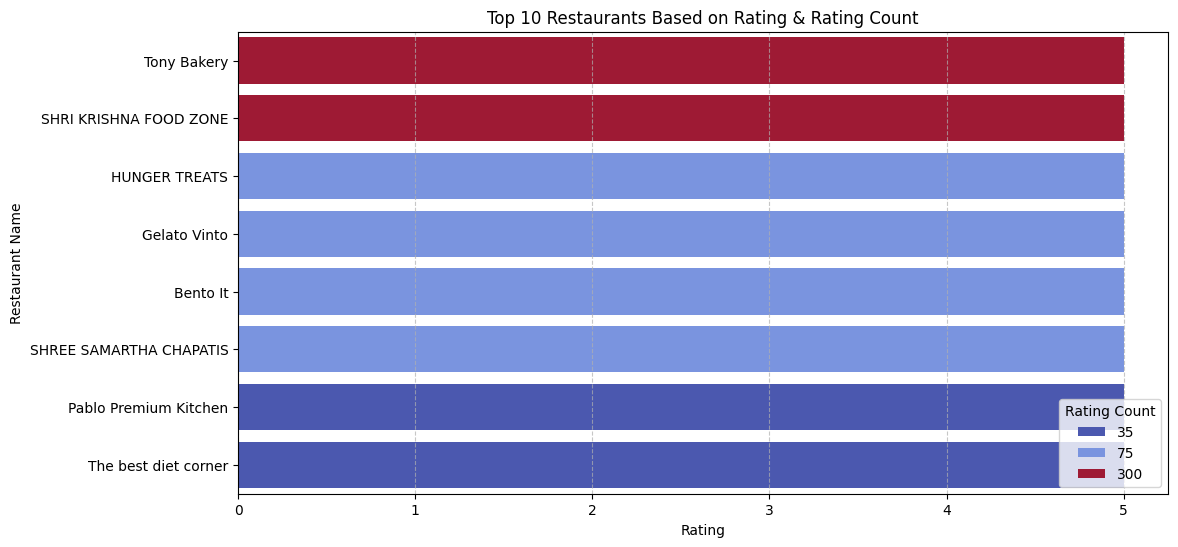

In [26]:
# Select top 10 restaurants based on rating and rating count
top_restaurants = df.sort_values(by=["rating", "rating_count"], ascending=[False, False]).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="rating", y="name", data=top_restaurants, hue="rating_count", palette="coolwarm", dodge=False)

plt.xlabel("Rating")
plt.ylabel("Restaurant Name")
plt.title("Top 10 Restaurants Based on Rating & Rating Count")
plt.legend(title="Rating Count", loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

<ipython-input-27-3351bb0632e2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_cuisines.values()), y=list(top_cuisines.keys()), palette="viridis")


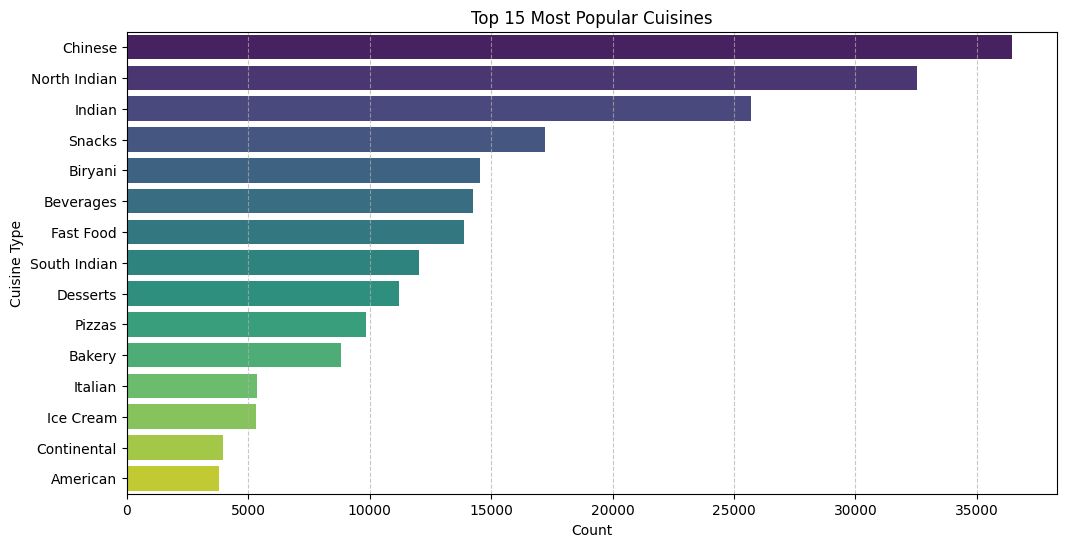

In [27]:
from collections import Counter

# Flatten the cuisine list
cuisine_list = [item.strip() for sublist in df["cuisine"].dropna().str.split(",") for item in sublist]

# Count occurrences
cuisine_counts = Counter(cuisine_list)
top_cuisines = dict(cuisine_counts.most_common(15))

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_cuisines.values()), y=list(top_cuisines.keys()), palette="viridis")

plt.xlabel("Count")
plt.ylabel("Cuisine Type")
plt.title("Top 15 Most Popular Cuisines")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()


Average Cost per Cuisine (Bar Chart)

<ipython-input-28-5597f716d098>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cuisine_avg_cost.values, y=cuisine_avg_cost.index, palette="coolwarm")


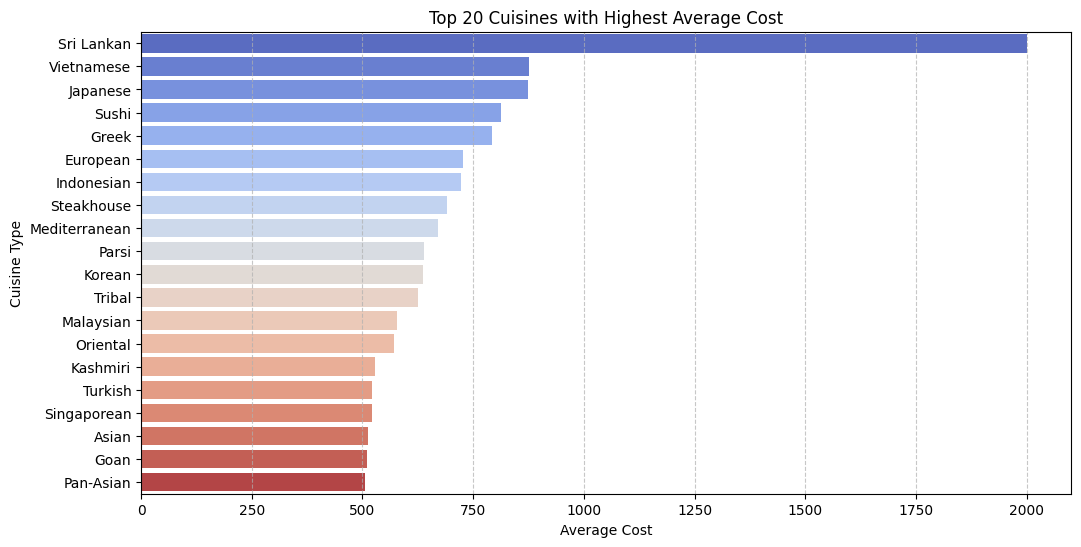

In [28]:
# Split and explode cuisine values into individual rows
cuisine_exploded = df.assign(cuisine=df["cuisine"].str.split(",")).explode("cuisine")
cuisine_exploded["cuisine"] = cuisine_exploded["cuisine"].str.strip()  # Remove spaces

# Group by cuisine and calculate average cost
cuisine_avg_cost = cuisine_exploded.groupby("cuisine")["cost"].mean().sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=cuisine_avg_cost.values, y=cuisine_avg_cost.index, palette="coolwarm")

plt.xlabel("Average Cost")
plt.ylabel("Cuisine Type")
plt.title("Top 20 Cuisines with Highest Average Cost")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

<ipython-input-29-e880d7996780>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette="coolwarm")


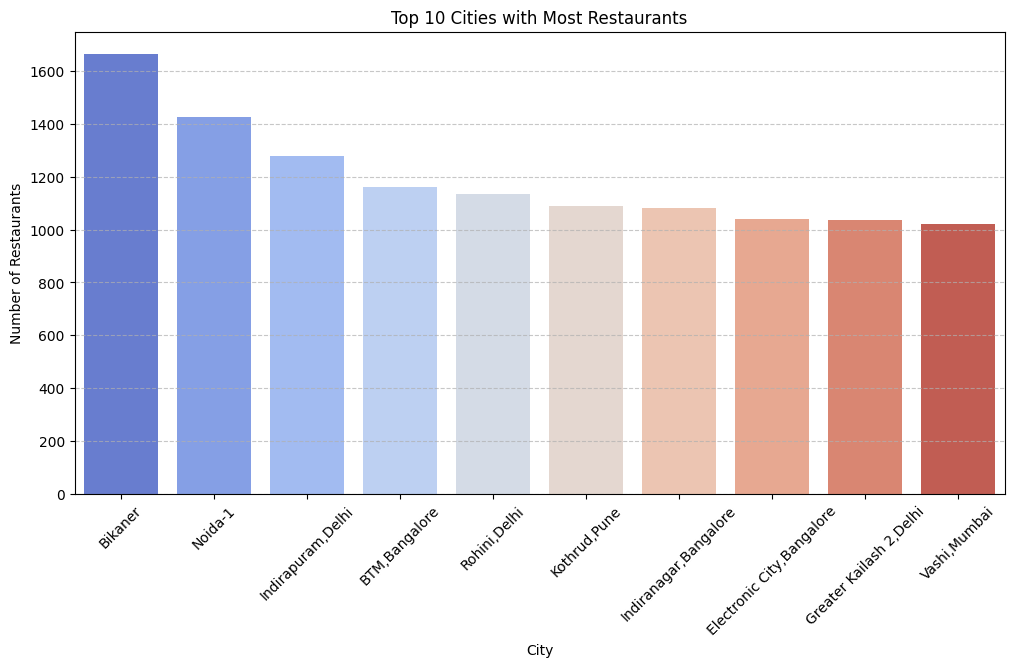

In [29]:
# Count the number of restaurants per city
city_counts = df["city"].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=city_counts.index, y=city_counts.values, palette="coolwarm")

plt.xlabel("City")
plt.ylabel("Number of Restaurants")
plt.title("Top 10 Cities with Most Restaurants")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

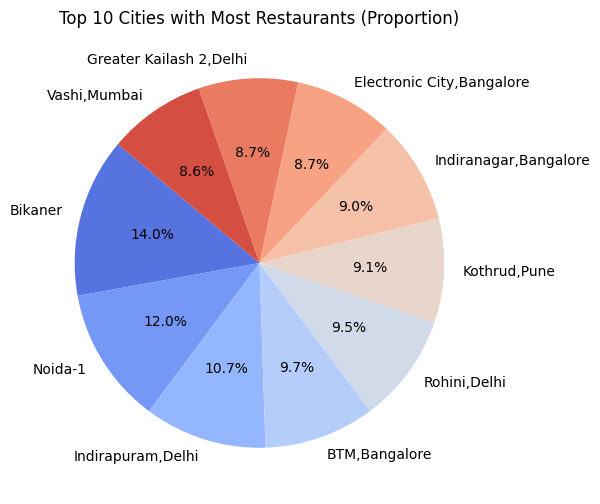

In [30]:
plt.figure(figsize=(10, 6))

# Plot Pie Chart
plt.pie(city_counts.values, labels=city_counts.index, autopct="%1.1f%%", colors=sns.color_palette("coolwarm", 10), startangle=140)

plt.title("Top 10 Cities with Most Restaurants (Proportion)")
plt.show()


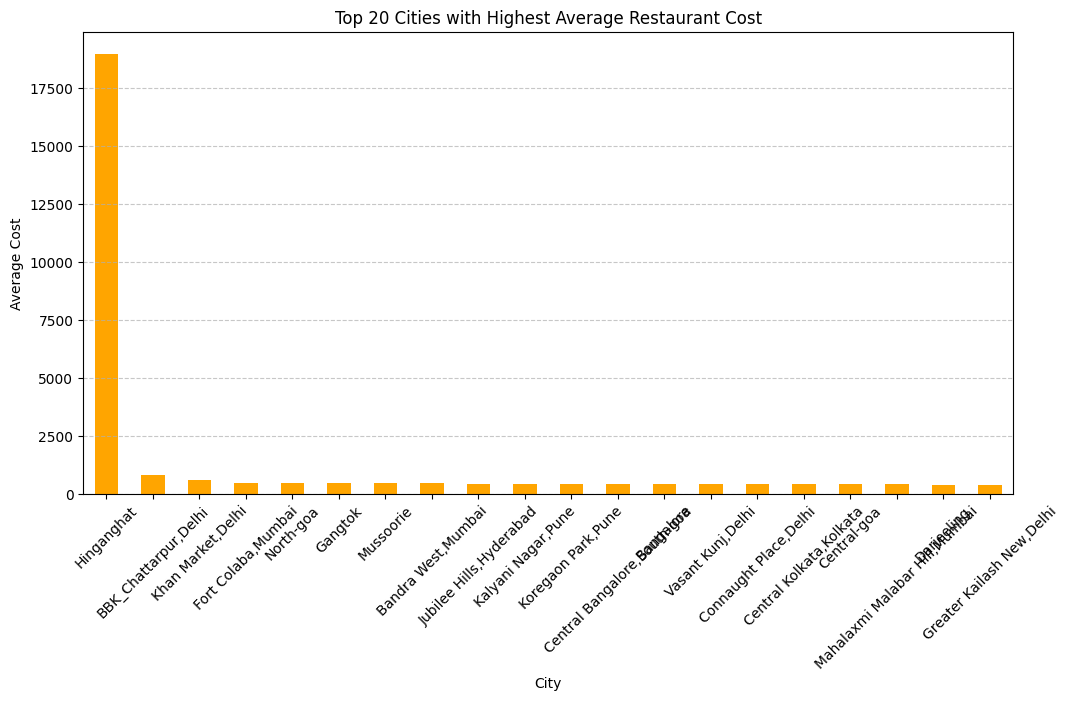

In [31]:
city_avg_cost = df.groupby("city")["cost"].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
city_avg_cost.plot(kind="bar", color="orange")

plt.xlabel("City")
plt.ylabel("Average Cost")
plt.title("Top 20 Cities with Highest Average Restaurant Cost")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [32]:
# Load cleaned data
df = pd.read_csv("/content/drive/MyDrive/guvii/projects dataset/cleaned_df.csv")

# Apply Label Encoding to 'name' and 'city'
city_encoder = LabelEncoder()
df["city_encoded"] = city_encoder.fit_transform(df["city"])

name_encoder = LabelEncoder()
df["name_encoded"] = name_encoder.fit_transform(df["name"])


In [34]:
from sklearn.preprocessing import OneHotEncoder

In [35]:
# Apply One-Hot Encoding to 'cuisine'
cuisine_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cuisine_encoded = cuisine_encoder.fit_transform(df[["cuisine"]])

# Convert One-Hot Encoded data into DataFrame
cuisine_encoded_df = pd.DataFrame(cuisine_encoded, columns=cuisine_encoder.get_feature_names_out(["cuisine"]))


In [36]:
df.head()

,name,city,rating,rating_count,cost,cuisine,link,address,city_encoded,name_encoded
0,AB FOODS POINT,Abohar,3.9,10,200.0,"Beverages,Pizzas",https://www.swiggy.com/restaurants/ab-foods-po...,"AB FOODS POINT, NEAR RISHI NARANG DENTAL CLINI...",1,1583
1,Janta Sweet House,Abohar,4.4,75,200.0,"Sweets,Bakery",https://www.swiggy.com/restaurants/janta-sweet...,"Janta Sweet House, Bazar No.9, Circullar Road,...",1,47417
2,theka coffee desi,Abohar,3.8,300,100.0,Beverages,https://www.swiggy.com/restaurants/theka-coffe...,"theka coffee desi, sahtiya sadan road city",1,112644
3,Singh Hut,Abohar,3.7,35,250.0,"Fast Food,Indian",https://www.swiggy.com/restaurants/singh-hut-n...,"Singh Hut, CIRCULAR ROAD NEAR NEHRU PARK ABOHAR",1,90303
4,GRILL MASTERS,Abohar,3.9,10,250.0,"Italian-American,Fast Food",https://www.swiggy.com/restaurants/grill-maste...,"GRILL MASTERS, ADA Heights, Abohar - Hanumanga...",1,34938


In [37]:
# Merge Encoded Features
df_encoded = pd.concat([df[["rating", "rating_count", "cost", "city_encoded", "name_encoded"]], cuisine_encoded_df], axis=1)


In [38]:
df_encoded.head()

,rating,rating_count,cost,city_encoded,name_encoded,cuisine_8:15 To 11:30 Pm,cuisine_Afghani,"cuisine_Afghani,American","cuisine_Afghani,Arabian","cuisine_Afghani,Bangladeshi",...,cuisine_Waffle,"cuisine_Waffle,Bakery","cuisine_Waffle,Beverages","cuisine_Waffle,Burgers","cuisine_Waffle,Chinese","cuisine_Waffle,Desserts","cuisine_Waffle,Fast Food","cuisine_Waffle,Ice Cream","cuisine_Waffle,Snacks",cuisine_nan
0,3.9,10,200.0,1,1583,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.4,75,200.0,1,47417,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.8,300,100.0,1,112644,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.7,35,250.0,1,90303,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.9,10,250.0,1,34938,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Standardizing rating, cost, and rating_count
rating_scaler = StandardScaler()
df_encoded[["rating", "cost", "rating_count"]] = rating_scaler.fit_transform(df_encoded[["rating", "cost", "rating_count"]])

In [41]:
import pickle

In [42]:
# Save all encoders and scalers in a single pickle file
encoders_scalers = {
    "city_encoder": city_encoder,
    "name_encoder": name_encoder,
    "cuisine_encoder": cuisine_encoder,
    "rating_scaler": rating_scaler
}

with open("/content/drive/MyDrive/guvii/projects dataset/encoders_scalers.pkl", "wb") as f:
    pickle.dump(encoders_scalers, f)

In [43]:
df_encoded.head()

,rating,rating_count,cost,city_encoded,name_encoded,cuisine_8:15 To 11:30 Pm,cuisine_Afghani,"cuisine_Afghani,American","cuisine_Afghani,Arabian","cuisine_Afghani,Bangladeshi",...,cuisine_Waffle,"cuisine_Waffle,Bakery","cuisine_Waffle,Beverages","cuisine_Waffle,Burgers","cuisine_Waffle,Chinese","cuisine_Waffle,Desserts","cuisine_Waffle,Fast Food","cuisine_Waffle,Ice Cream","cuisine_Waffle,Snacks",cuisine_nan
0,0.007745,-0.289891,-0.109948,1,1583,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.697060,-0.136822,-0.109948,1,47417,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.330118,0.393033,-0.235480,1,112644,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.667981,-0.231019,-0.047182,1,90303,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.007745,-0.289891,-0.047182,1,34938,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X = df_encoded.drop(columns=["name_encoded"], errors="ignore")

In [45]:
# Train the K-Means model
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X)

# Save the trained model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

print("✅ K-Means model trained and saved successfully!")

✅ K-Means model trained and saved successfully!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate WCSS for different values of k
wcss = []
for i in range(1, 11):  # Trying k from 1 to 10
    kmeans_temp = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans_temp.fit(X)
    wcss.append(kmeans_temp.inertia_)  # Inertia = WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Define the number of clusters based on the elbow method
optimal_k = 5  # Replace with the best k from your elbow plot

# Train the K-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Compute Metrics
wcss = kmeans.inertia_  # WCSS (Within-Cluster Sum of Squares)
silhouette_avg = silhouette_score(X, cluster_labels)
davies_bouldin = davies_bouldin_score(X, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

# Print Metrics
print(f"📌 WCSS: {wcss:.2f} (Lower is better)")
print(f"📌 Silhouette Score: {silhouette_avg:.4f} (Higher is better)")
print(f"📌 Davies-Bouldin Index: {davies_bouldin:.4f} (Lower is better)")
print(f"📌 Calinski-Harabasz Index: {calinski_harabasz:.2f} (Higher is better)")
